# Comparing Neighbourhoods in New York to Measure competition for New Chinese Restaurant

Project description

New York metropolitan area is home to the largest and most prominent ethnic Chinese population outside of Asia. The Chinese American population of the New York City metropolitan area was an estimated 893,697 as of 2017. New York City itself contains by far the highest ethnic Chinese population of any individual city outside Asia, estimated at 628,763 as of 2017.

The objective of this project is to understand the number of chinese restaurants in each borough in New York and see if there is scope for me opening a new chinese restaurant in the area. The key measures will be understanding the number of chinese restaurants in the area and also their average rating so that we have a good understanding of both in order to make my decision.

Overview of Data and Approach to Using it:

Data:
New York city Borough and Neghbourhood data source : https://cocl.us/new_york_dataset
This data will be used to explore various neighborhoods of new york city.
Chinese resturants in each neighborhood of new york city will be sourced from foursqaure API. We will be able to get all chinese restaurants by borough using this source.

Approach:
Collect the new york city data from https://cocl.us/new_york_dataset
Get all restaurants in each area and all venues that are Chinese Resturants.
Find tips and ratings for each Chinese Resturant using FourSquare API.
Visualize the Ranking of neighborhoods.

Decison:
We will consider the above when deciding where to open the restaurant.


In [21]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
%matplotlib inline

print('Libraries imported.')
print('Libraries done.')

Libraries imported.
Libraries done.


In [22]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [220]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'CNOXYHHDTBMQAC2TS5RZ4SKEFYIQIXFXDOQLHGID4FQJBRTN'
    CLIENT_SECRET = 'WMXY1LZ5GLAMVJT5LYMKAJMCFH22A5HZXGLXKRHLWEGXGROV'
    VERSION = '20180605' # Foursquare API version

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [221]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'CNOXYHHDTBMQAC2TS5RZ4SKEFYIQIXFXDOQLHGID4FQJBRTN'
    CLIENT_SECRET = 'WMXY1LZ5GLAMVJT5LYMKAJMCFH22A5HZXGLXKRHLWEGXGROV'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [222]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [189]:
# get new york data
new_york_data=get_new_york_data()

In [214]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [213]:
new_york_data.shape

(306, 4)

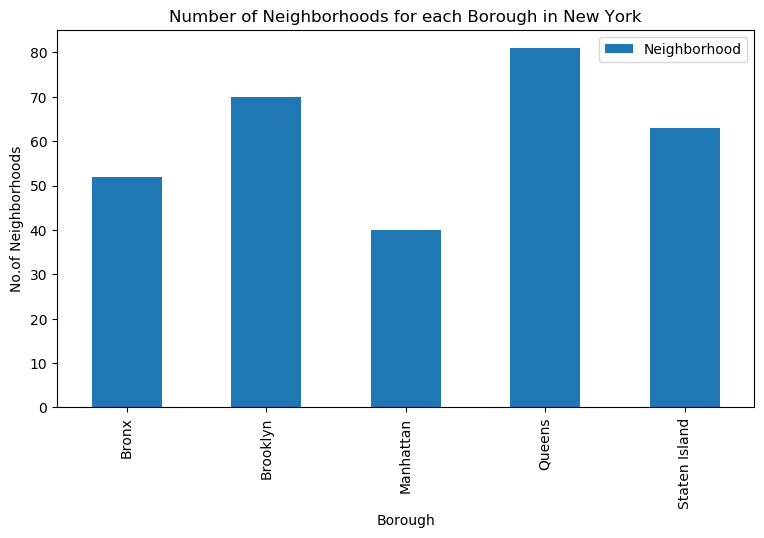

In [215]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York')
#On x-axis
plt.xlabel('Boroughs', fontsize = 10)
#On y-axis
plt.ylabel('No.of Neighborhoods', fontsize=10)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has largest number of Chinese restaurants, followed by Brooklyn and Staten Island.

In [206]:
# prepare neighborhood list that contains Chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(Chinese_resturants)))
    for resturant_detail in Chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        Chinese_rest_ny = Chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:2
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:2
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:2
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:1
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:3
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:2
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:5
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:4
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:1
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:3
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:2
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:2
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:2
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:2
( 145 / 306 ) Chinese Resturants in Glendale, Queens:1
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:2
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:4
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:2
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:2
( 150 / 306 ) Chinese Resturants in College Point, Queens:2
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:1
( 152 / 306 ) Chinese Resturants in Bayside, Queens:0
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:2
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:5
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:3
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:0
( 158 / 306 ) Chinese Resturants

( 276 / 306 ) Chinese Resturants in Stuyvesant Town, Manhattan:1
( 277 / 306 ) Chinese Resturants in Flatiron, Manhattan:1
( 278 / 306 ) Chinese Resturants in Sunnyside Gardens, Queens:0
( 279 / 306 ) Chinese Resturants in Blissville, Queens:2
( 280 / 306 ) Chinese Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Chinese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Chinese Resturants in Weeksville, Brooklyn:3
( 283 / 306 ) Chinese Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Chinese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Chinese Resturants in Manor Heights, Staten Island:2
( 286 / 306 ) Chinese Resturants in Willowbrook, Staten Island:2
( 287 / 306 ) Chinese Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Chinese Resturants in Egbertville, Staten Island:1
( 289 / 306 ) Chinese Resturants in Roxbury, Queens:0
( 290 / 306 ) Chinese Resturants in Homecrest, Brooklyn:2
( 291 / 306 ) Chinese Resturants in Middle Village, Queens:2
( 292 / 306 ) Chine

In [216]:
Chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4e2710b7a809510950dd6b32,Double Dragon
2,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
4,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant


In [217]:
Chinese_rest_ny.shape

(429, 4)

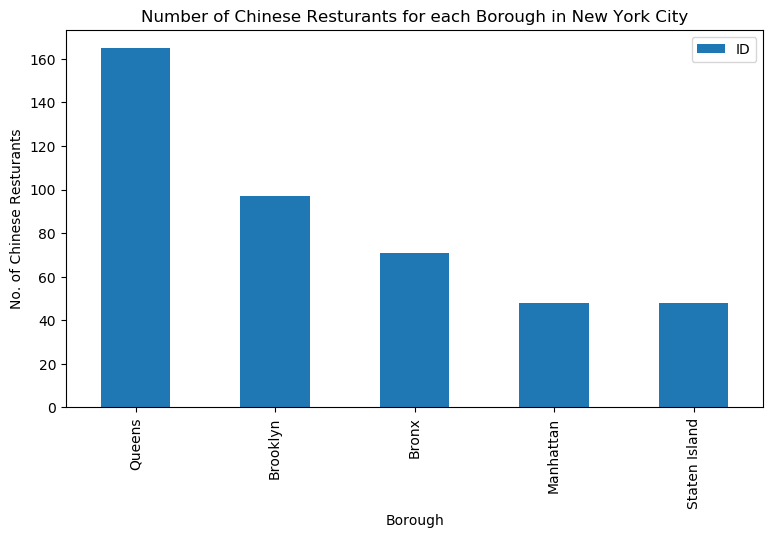

In [248]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('No. of Chinese Resturants', fontsize=10)
#giving a bar plot
Chinese_rest_ny.groupby('Borough')['ID'].count().nlargest(10).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [211]:
Chinese_rest_ny[Chinese_rest_ny['Neighborhood']=='Flushing']

C:\Users\teren\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Borough,Neighborhood,ID,Name


In [223]:
# prepare neighborhood list that contains Chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Chinese_rest_ny),')','processed')
    Chinese_rest_stats_ny = Chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    


Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e2710b7a809510950dd6b32
( 2 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 3 / 429 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     4.9    10
( 4 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 5 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4df7aabd4101d0d79f4760
( 6 / 429 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b2286f1f964a5205a4824e3  Hunan Balcony     13     6.7     7
( 7 / 429 ) processe

                         ID                             Name  Likes  Rating  \
0  4b89b62df964a520ff4c32e3  Sabor Latino Seafood Restaurant      6     6.9   

   Tips  
0     8  
( 56 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4df7a9bd4101d0d79f472f
( 57 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 58 / 429 ) processed
                         ID        Name  Likes  Rating  Tips
0  4a5beec3f964a52006bc1fe3  86 Noodles     19     7.6    22
( 59 / 429 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4b1c3b4cf964a520bb0424e3  Grand Sichuan House     36     8.1    23
( 60 / 429 ) processed
                         ID Name  Likes  Rating  Tips
0  5553702c498ecb85f99d8f37  XIN      6     7.1     4
( 61 / 429 ) processed
                         ID            Name  Likes  Rating  Tips
0  574a1a534

                         ID            Name  Likes  Rating  Tips
0  4b5a6114f964a52043c128e3  China New Star     57     8.8    19
( 111 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c85489ec5a995212abf9305
( 112 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4be32bd7b02ec9b61fc34ec0
( 113 / 429 ) processed
                         ID     Name  Likes  Rating  Tips
0  4a71ff01f964a52016da1fe3  Kum Kau    109     7.9    77
( 114 / 429 ) processed
                         ID         Name  Likes  Rating  Tips
0  59da9590e1f0aa52976b8f35  Han Dynasty    148     8.8    30
( 115 / 429 ) processed
                         ID       Name  Likes  Rating  Tips
0  585d72449f25836f2b2b7a1b  Xifu Food     24     8.6     9
( 116 / 429 ) processed
                         ID       Name  Likes  Rating  Tips
0  585d72449f25836f2b2b7a1b  Xifu Food     24     8.6     9
( 117 / 42

                         ID        Name  Likes  Rating  Tips
0  5237264111d27e8e90c10357  China Blue    340     8.8    82
( 165 / 429 ) processed
                         ID                Name  Likes  Rating  Tips
0  5894c9a15e56b417cf79e553  Xi'an Famous Foods     93     8.9    27
( 166 / 429 ) processed
                         ID   Name  Likes  Rating  Tips
0  526eeb54498e9674b5d9034a  Decoy    323     9.1   104
( 167 / 429 ) processed
                         ID     Name  Likes  Rating  Tips
0  4e1df590b61c7cb34d9735a8  RedFarm    701     8.8   283
( 168 / 429 ) processed
                         ID                Name  Likes  Rating  Tips
0  529e3657498efb17e9c800b7  Xi'an Famous Foods    294     8.5    78
( 169 / 429 ) processed
                         ID     Name  Likes  Rating  Tips
0  59ac42570868a23a1e0fde8f  Red Hot      9     7.9     1
( 170 / 429 ) processed
                         ID                     Name  Likes  Rating  Tips
0  58fbdc8fe0755067a6dcf3ee  108 Food- D

                         ID     Name  Likes  Rating  Tips
0  4ba25cdff964a52051f137e3  Mr Chen      8     6.9    13
( 217 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bd9fe963904a5939194449e
( 218 / 429 ) processed
                         ID            Name  Likes  Rating  Tips
0  56316c73498ebdd0e0e53e95  Green Zenphony     18     8.1     7
( 219 / 429 ) processed
                         ID        Name  Likes  Rating  Tips
0  4edac00e0aaf49e02a0e2f73  Tasty & Co     12     7.1     4
( 220 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4ce1d4bd413c4cc66ced44
( 221 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4de06d3ed164e323c7ad25ee
( 222 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e3f1364b0fb875af8786fcd
( 223 / 429 ) pr

                         ID           Name  Likes  Rating  Tips
0  4c6efa6ed7fab1f73b055ac9  Kam's Kitchen      4     5.6     4
( 272 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4cf2e1107bf3b60c9320687f
( 273 / 429 ) processed
                         ID       Name  Likes  Rating  Tips
0  4e4e41e8bd4101d0d7a620e0  Magic Wok     13     8.1     8
( 274 / 429 ) processed
                         ID           Name  Likes  Rating  Tips
0  4eb9c26046906fa3574d411f  Lucky Cornaga      7     7.2     0
( 275 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4e41e9bd4101d0d7a620eb
( 276 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c369b8a3849c928d56cbcb1
( 277 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4de6e9acae60db140a896bd3
( 278 / 

                         ID                     Name  Likes  Rating  Tips
0  4be75c8f2468c928fc720243  Tack's Chinese Take Out      7     7.1     8
( 327 / 429 ) processed
                         ID          Name  Likes  Rating  Tips
0  4c14210c7f7f2d7fae69e068  Crown Palace      9     5.8     5
( 328 / 429 ) processed
                         ID                              Name  Likes  Rating  \
0  4b747adcf964a52010df2de3  Lucky Fortune Chinese Restaurant      8     6.5   

   Tips  
0     6  
( 329 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c292b6eed0ac9b68a6561aa
( 330 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d1a8eae02a66dcb2c506165
( 331 / 429 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c1ad571eac020a10a0144c2  China Hao Restaurant     31     8.5    15
( 332 / 429 ) processed
                       

                         ID       Name  Likes  Rating  Tips
0  51d81d9e5019b8b339258089  Xing Chef      8     7.6     3
( 382 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bcb906ecc8cd13ac3b3bfcf
( 383 / 429 ) processed
                         ID               Name  Likes  Rating  Tips
0  4ce9aeae678aa093b7a0efea  Merry Land Buffet     12     7.1     3
( 384 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f3288a219836c91c7e12861
( 385 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4d0475bd413c4cc66e056d
( 386 / 429 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ded52a2ae6052cbed0423a8
( 387 / 429 ) processed


KeyError: 'venue'

In [225]:
Chinese_rest_stats_ny.shape

(387, 7)

In [ ]:
Chinese_rest_ny.shape

In [229]:
Chinese_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [228]:
Chinese_rest_stats_ny_csv.shape

NameError: name 'Chinese_rest_stats_ny_csv' is not defined

In [230]:
Chinese_rest_stats_ny['Likes']=Chinese_rest_stats_ny['Likes'].astype('float64')

In [231]:
Chinese_rest_stats_ny['Tips']=Chinese_rest_stats_ny['Tips'].astype('float64')

In [236]:
Chinese_rest_stats_ny['Rating']=Chinese_rest_stats_ny['Rating'].astype('float64')

In [232]:
# Resturant with maximum Likes
Chinese_rest_stats_ny.iloc[Chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1454
Rating                               9.2
Tips                                 509
Name: 158, dtype: object

In [237]:
Chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 7 columns):
Borough         387 non-null object
Neighborhood    387 non-null object
ID              387 non-null object
Name            387 non-null object
Likes           387 non-null float64
Rating          387 non-null float64
Tips            387 non-null float64
dtypes: float64(3), object(4)
memory usage: 21.2+ KB


In [239]:
# Resturant with maximum Rating
Chinese_rest_stats_ny.iloc[Chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1454
Rating                               9.2
Tips                                 509
Name: 158, dtype: object

In [240]:
# Resturant with maximum Tips
Chinese_rest_stats_ny.iloc[Chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1454
Rating                               9.2
Tips                                 509
Name: 158, dtype: object

In [241]:
ny_neighborhood_stats=Chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [242]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
25,Chelsea,9.20
179,Windsor Terrace,9.10
73,Greenwich Village,9.10
46,East Village,9.00
118,Noho,9.00
173,West Village,8.95
167,Upper West Side,8.90
156,South Side,8.90
114,Murray Hill,8.90
105,Midtown South,8.90


In [258]:
ny_borough_stats=Chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [259]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.139535
1,Brooklyn,4.393023
3,Queens,4.174359
4,Staten Island,3.192683
0,Bronx,2.193443


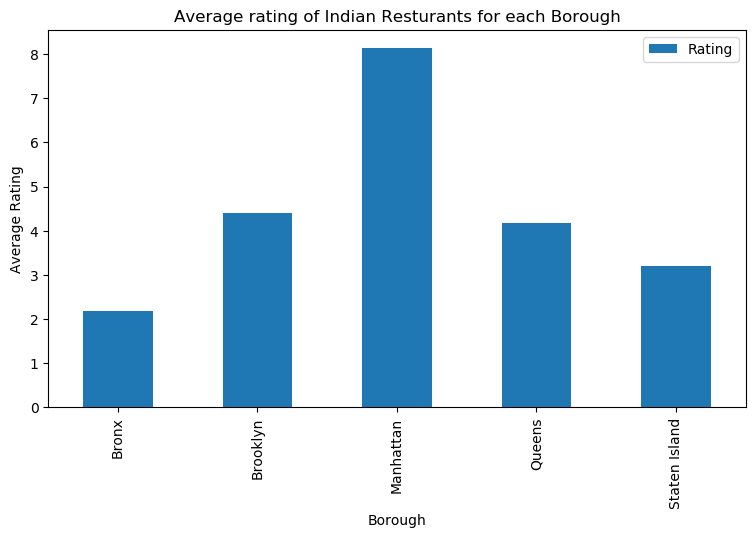

In [247]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 10)
#On y-axis
plt.ylabel('Average Rating', fontsize=10)
#giving a bar plot
Chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [249]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [250]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [251]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Staten Island,Arden Heights,40.549286,-74.185887,0.000000
1,Staten Island,Arrochar,40.596313,-74.067124,0.000000
2,Queens,Astoria Heights,40.770317,-73.894680,3.800000
3,Queens,Auburndale,40.761730,-73.791762,0.000000
4,Brooklyn,Bath Beach,40.599519,-73.998752,4.240000
5,Brooklyn,Bay Ridge,40.625801,-74.030621,7.600000
6,Queens,Bay Terrace,40.782843,-73.776802,4.466667
7,Staten Island,Bay Terrace,40.553988,-74.139166,4.466667
8,Bronx,Baychester,40.866858,-73.835798,1.400000
9,Bronx,Bedford Park,40.870185,-73.885512,6.400000


In [252]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [253]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [254]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [257]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion

Queens has the most chinese restuarants but rated only 3rd best Borough.
Manhattan have the best Chinese restaurants on average based on rating.
Brooklyn has the second best rated chinese restaurants on average. 
I would consider opening a restaurant in Queens even though there are many restaurants there. I may gain an advantage by opening a quality restaurants with good service and food since ratings on average in queens for existing restaurants are not great.